This is a modified Version of Chris's notebook:https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676

In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score

# Load Train Data and Labels

In [2]:
train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv')

In [3]:
train['room_coor_x'] = train['room_coor_x'].fillna(0)
train['room_coor_y'] = train['room_coor_y'].fillna(0)
train['screen_coor_x'] = train['screen_coor_x'].fillna(0)
train['screen_coor_y'] = train['screen_coor_y'].fillna(0)
train['hover_duration'] = train['hover_duration'].fillna(0)
train['page'] = train['page'].fillna(-1)

In [4]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(212022, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


# Feature Engineer
We create basic aggregate features. Try creating more features to boost CV and LB! The idea for EVENTS feature is from [here][1]

[1]: https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data

In [5]:
NUNIQUE = ['event_name','fqid', 'room_fqid', 'text']
MMS = ['elapsed_time', 'hover_duration','index'] # mean,std
MEAN = ['level','page']
STD = ['room_coor_x', 'room_coor_y','screen_coor_x','screen_coor_y']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']
SUM = ['index']

In [6]:
def feature_engineer(train):
    dfs = []
    for c in NUNIQUE:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    # for c in MMS:
    #     tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
    #     tmp.name = tmp.name + '_mean'
    #     dfs.append(tmp)
    for c in MMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('max')
        tmp.name = tmp.name + '_max'
        dfs.append(tmp)
    for c in MMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('min')
        tmp.name = tmp.name + '_min'
        dfs.append(tmp)
    for c in MMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in MEAN:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in STD:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in SUM:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in EVENTS:
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
    df = pd.concat(dfs,axis=1)
    # df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [7]:
%%time
df = feature_engineer(train)
print( df.shape )
df.head()

(35337, 31)
CPU times: user 59.3 s, sys: 969 ms, total: 1min
Wall time: 1min


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_max,hover_duration_max,index_max,elapsed_time_min,hover_duration_min,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,194860,7899.0,164,0,0.0,...,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1,14155937
20090312431273200,13-22,10,49,12,168,1272679,4750.0,931,836732,0.0,...,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1,437052322
20090312431273200,5-12,10,39,11,124,499235,4183.0,470,221485,0.0,...,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1,105732736
20090312433251036,0-4,11,22,6,49,233752,5567.0,138,0,0.0,...,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1,13571045
20090312433251036,13-22,11,73,16,183,3815334,22351.0,1875,1176483,0.0,...,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1,3241011333


# Train XGBoost Model
We train one model for each of 18 questions. Furthermore, we use data from `level_groups = '0-4'` to train model for questions 1-3, and `level groups '5-12'` to train questions 4 thru 13 and `level groups '13-22'` to train questions 14 thru 18. Because this is the data we get (to predict corresponding questions) from Kaggle's inference API during test inference. We can improve our model by saving a user's previous data from earlier `level_groups` and using that to predict future `level_groups`.

In [8]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 30 features
We will train with 11779 users info


You can also use grid search and Bayesian optimization methods

In [9]:
gkf = GroupKFold(n_splits=20)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.005,
    'max_depth': 4,
    'n_estimators': 1500,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1(1499), 2(1326), 3(1062), 4(1328), 5(972), 6(531), 7(1339), 8(607), 9(850), 10(1142), 11(996), 12(544), 13(674), 14(903), 15(1087), 16(831), 17(771), 18(1500), 
#########################
### Fold 2
#########################
1(1493), 2(839), 3(1002), 4(1489), 5(809), 6(710), 7(873), 8(623), 9(779), 10(1333), 11(898), 12(734), 13(1012), 14(605), 15(959), 16(479), 17(447), 18(1035), 
#########################
### Fold 3
#########################
1(1500), 2(826), 3(1312), 4(1115), 5(609), 6(643), 7(529), 8(457), 9(1060), 10(551), 11(983), 12(838), 13(862), 14(706), 15(704), 16(891), 17(785), 18(1458), 
#########################
### Fold 4
#########################
1(1271), 2(1111), 3(887), 4(1137), 5(1183), 6(1180), 7(801), 8(385), 9(394), 10(716), 11(1013), 12(682), 13(623), 14(1123), 15(660), 16(435), 17(663), 18(972), 
#########################
### Fold 5
#########################
1(1500), 2(1397), 3(1076), 4(1319), 5(839),

# Compute CV Score
We need to convert prediction probabilities into `1s` and `0s`. The competition metric is F1 Score which is the harmonic mean of precision and recall. Let's find the optimal threshold for `p > threshold` when to predict `1` and when to predict `0` to maximize F1 Score.

In [10]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [11]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

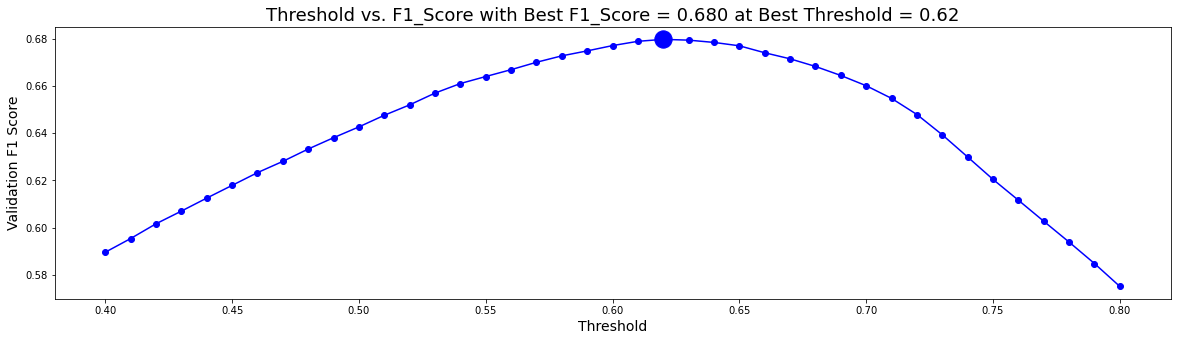

In [12]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [13]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.60613200139209
Q1: F1 = 0.4946153516111039
Q2: F1 = 0.48600449581649685
Q3: F1 = 0.6089439824403108
Q4: F1 = 0.574528931553344
Q5: F1 = 0.6044762902143804
Q6: F1 = 0.5900999527393911
Q7: F1 = 0.5280867047939785
Q8: F1 = 0.6022869048001157
Q9: F1 = 0.5074771398795856
Q10: F1 = 0.5953150420004631
Q11: F1 = 0.4939001818721721
Q12: F1 = 0.43992171532683544
Q13: F1 = 0.611530199171884
Q14: F1 = 0.5053477161316741
Q15: F1 = 0.45075559765313383
Q16: F1 = 0.5371307836954806
Q17: F1 = 0.4888189337172301
==> Overall F1 = 0.6798376650871869


# Infer Test Data

In [14]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# CLEAR MEMORY
import gc
del train, targets, df, oof, true
_ = gc.collect()

In [15]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (sample_submission, test) in iter_test:
    test['room_coor_x'].fillna(0)
    test['room_coor_y'].fillna(0)
    test['screen_coor_y'].fillna(0)
    test['screen_coor_x'].fillna(0)
    test['hover_duration'].fillna(0)
    test['page'].fillna(-1)
    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)
    
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[:,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int(p.item()>best_threshold)
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


# EDA submission.csv

In [16]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090312143683264_q1,0
4,20090312143683264_q2,1


In [17]:
print(df.correct.mean())

0.5370370370370371
